In [161]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import re
import scipy.constants as c
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import welch
from scipy.signal import find_peaks
from scipy.signal import periodogram
from scipy.interpolate import interp1d
import scipy.signal as sig
import math
import string


# Split into like 1000 sections for each trace, average those and find variance of each slice.
# Allan variance (do it).

In [5]:
# Functions to be fitted.
def sqq(omega,omegaq,Gammacm,Tcm,M):
    return ((abs(Gammacm)*c.k*abs(Tcm))/(np.pi*abs(M)))/((omega**2-abs(omegaq)**2)**2+(abs(Gammacm)**2)*(abs(omega)**2))

def ssqq(omega,omegaq,Gammacm,a):
    return ((abs(Gammacm)*abs(a))/((omega**2-abs(omegaq)**2)**2+(abs(Gammacm)**2)*(abs(omega)**2)))

In [381]:
# Misc.
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def progress_bar(i,L,w):
    pr = i/L
    print(2*w*' ', end = '\r')
    print('[{}{}]{}/100%'.format(int(w*pr)*'#',int(w*(1-pr))*'.',round(100*pr,1)),end='\r')

def count_e(nested_list):
    return sum(count_elements_nested_list(item) if isinstance(item, list) else 1 for item in nested_list)

class Rod_Gamas:
    def __init__(self, T_s, l, R, D, p):
        self.l = l
        self.R = R
        self.p = p
        self.T = 300
        self.M = np.pi * R**2 * l * D
        self.alpha_c = 0.65 # Assuming surrounding gas is N_2.
        self.gamma_s = np.sqrt(T_s/self.T) # T_s = surface temp, # T = gas temp; (maybe ~1).
        self.m = 28.0134/(1000*c.N_A) # Mass of gas molecule (N_2).
        self.ng  = p/(c.k*self.T) # Gas density.

    def cm_t(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (2+self.alpha_c(-1/2 + np.pi*self.gamma_s/4 + self.R/self.l))

    def cm_p(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (4*self.R/self.l+self.alpha_c*(1 - 2*self.R/self.l + np.pi*self.gamma_s*self.R/(2*self.l)))

    def rot_t(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * (self.l**2/(3*self.R**2 + self.l**2))* (2 + 12*(self.R/self.l)**3 + self.alpha_c*(-1/2 + np.pi*self.gamma_s/4 + 3*self.R/self.l + 6*(self.R/self.l)**2 + (3*np.pi*self.gamma_s/2 - 6)*(self.R/self.l)**3))

    def rot_p(self):
        return (self.ng*self.R*self.l*np.sqrt(2*np.pi*self.m*c.k*self.T)/self.M) * self.alpha_c*(2+ self.R/self.l)
 
class data_loader:
    def __init__(self, dataloc):
        fileNames = [f for f in listdir(dataloc) if isfile(join(dataloc, f)) and f[-4:] == '.mat' and f[:8].isnumeric()]
        fileNames.sort(key=lambda f: int(re.sub('\D', '', f)))
        fileNames = fileNames[:-1] # Cut the last file off as it is an unpredicatble length.

        self.d = [loadmat(dataloc+'\\'+ fileName) for fileName in fileNames]

class data_processing:
    def __init__(self, d, CH):
        self.d = d
    
        self.CH = CH

        self.Ti = d[0]['Tinterval'][0,0]
        self.l = d[0]['Length'][0,0]

    def plot_time_series(self):
        plt.figure(figsize=(10, 3.5), dpi=80)
        plt.plot(np.linspace(0,self.l*self.Ti,self.l),self.d[0][self.CH],color='tab:red')
        plt.title('Time Series Data (CH {})'.format(self.CH))
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.show()
        
    def plot_full_PSD(self):
        plt.figure(figsize=(10, 3.5), dpi=80)
        xf, pxx = periodogram(self.d[0][self.CH][:,0],fs=1/self.Ti)
        plt.semilogy()
        plt.plot(xf,pxx,color='black')
        plt.show()
        
    def split_data(self, freq = 3e5, osc = 1e4):
        split_data = []
        split_length = int(self.l*self.Ti/(osc*(1/freq)))
        
        for i in range(len(self.d)):
            r = (self.d[0][self.CH])[:,0].shape[0]%split_length
            split_data.append(np.split((self.d[0][self.CH])[:-r,0], split_length))

        return np.asarray(split_data)
    
    def average(self, split_data):
        # Find Summed PSDs.
        lpxx = []
        # For each channel, adds all periodograms generated from d seperate runs together.
        for i in range(len(self.d)):
            for j in range(split_data.shape[1]):
                # This is done to limit too much memory allocation.
                if i == 0: 
                    xf, pxx = periodogram(split_data[i,j,:],fs=1/self.Ti)
                else:
                    _, pxx = periodogram(split_data[i,j,:],fs=1/self.Ti)
                lpxx.append(pxx[1:])
                
        lpxx = np.asarray(lpxx)
        mpxx = np.mean(lpxx, axis= 0 )
        spxx = np.std(lpxx, axis= 0 )
        epxx = np.std(lpxx, axis= 0 )/np.sqrt(lpxx.shape[0])
        return xf[1:], mpxx, spxx, epxx

    def plot_mean_errorbars(self, processed_data):
        xf, mpxx, epxx = processed_data[0], processed_data[1], processed_data[3]
        plt.semilogy()
        plt.errorbar(xf, mpxx, yerr = epxx, marker='', linestyle='')
        plt.title('PSD Data (log10)')
        plt.xlabel('Freq. (Hz)')
        plt.ylabel('PSD ($V^2/Hz$)')
        plt.show()

class fit_data:
    def __init__(self, processed_data):
        self.processed_data = processed_data
        self.peak_params = [[],[]]
        self.popt = []
        self.pcov = []
        self.labels = []
        
        
    def find_peaks(self, width_tuning, peak_lim = 50):
        #width_tuning = 11
        #peak_lim = 50
        peak_list = []
        amp_list = []
        
        xf = self.processed_data[0]
        mpxx = self.processed_data[1]

        #progress_bar(i,len(CH),40)
        plt.figure(figsize=(10, 3.5), dpi=80)
        plt.semilogy()
        plt.plot(xf, mpxx,color='black')
        plt.title('PSD Data (log10)')
        plt.xlabel('Freq. (Hz)')
        plt.ylabel('PSD ($V^2/Hz$)')
        peaks = find_peaks(mpxx, width = width_tuning)[0]
        print('Peaks: {}'.format(len(peaks)))

        if len(peaks) > peak_lim:
            print('Error: Too Many Peaks')
        for j in range(len(peaks)):
            plt.axvline(x=xf[peaks[j]],color='tab:red')
            peak_list.append(xf[peaks[j]])
            amp_list.append(mpxx[peaks[j]])
        peaks = np.append(peaks, [1200]) #Temporary additional peak
        peak_list.append(55000) #Temporary additional peak
        amp_list.append(2e-9) #Temporary additional peak
        p = len(peak_list)
        plt.show()
        self.peak_params = [p, peaks, peak_list, amp_list]
        
    def fit_multipeak(self, a, b, c, d, gamma, amp, peak_search_area = 250):
        xf, mpxx, spxx, epxx = self.processed_data[0], self.processed_data[1], self.processed_data[2], self.processed_data[3]
        p, peaks, peak_list, amp_list = self.peak_params

        # Build multi func.
        vs = 'omega, a, b, c, d,'
        funcString1 = "def multi_peak({}):"
        funcString2 = ' a/((omega-d)**b) + c +'
        for i in range(p):
            vs+=' omegaq{}, Gammacm{}, a{},'.format(i,i,i)
            funcString2 += ' ssqq(omega, omegaq{}, Gammacm{}, a{}) +'.format(i,i,i)
        funcString2 = funcString2[:-2]
        funcString1 = funcString1.format(vs)
        funcString = funcString1 + '\n return' +  funcString2

        exec(funcString, globals())
        
        lowerBound = ()
        upperBound = ()
        lowerBound += (0,)
        upperBound += (np.inf,)
        lowerBound += (0.01,)
        upperBound += (3,)
        lowerBound += (0,)
        upperBound += (np.inf,)
        lowerBound += (0,)
        upperBound += (np.inf,)
        #Initial Guesses
        p0g = [a, b, c, d]
        for i in range(p):
            lb = peak_list[i]-peak_search_area
            if lb < 0:
                lb = 0
            ub = peak_list[i]+peak_search_area
            if ub > xf[-1]:
                ub = xf[-1]
            lowerBound += (lb,)
            upperBound += (ub,)
            p0g.append(peak_list[i]) # Peak pos guesses.
            lowerBound += (0,)
            upperBound += (np.inf,) 
            p0g.append(gamma) # Gamma Guess
            lowerBound += (0,)
            upperBound += (np.inf,)
            p0g.append(amp_list[i]*amp*1e14) # amp guesses
        #Fitting
        self.popt, self.pcov = curve_fit(multi_peak, xf, mpxx,
                               sigma = spxx, absolute_sigma = True, bounds = (lowerBound, upperBound), p0 = p0g)

    def peak_identification(self, bounds = 1000):
        popt = self.popt
        pcov = self.pcov
        peaks = self.peak_params[1]
        amp_list = self.peak_params[3]
        #Harmonic identification
        #bounds = 1000 #bound on identification for harmonics
        h_order = 1 #max order to identify, fundamental is order 1
        harmonic = np.zeros((len(peaks),h_order))
        for i in range(len(peaks)):
            for j in range(len(peaks)):
                for k in range(h_order):
                    if popt[4+3*i] >= (k+2)*popt[4+3*j] - bounds and popt[4+3*i] <= (k+2)*popt[4+3*j] + bounds:
                        harmonic[i,k] = j
        #Sideband identification
        bounds = 1500 #bound on identification for sidebands
        harm = np.sum(harmonic,1) # used to ignore harmonics
        s_order = 2 #order of sidebands
        s = [y for y in range(-1*s_order, s_order+1, 1) if y!=0]
        sideband = np.zeros((len(peaks),2,2*s_order))
        for i in range(len(peaks)):
            for j in range(len(peaks)):
                for k in range(len(peaks)):
                    for l in range(len(s)):
                        if popt[4+3*i] >= popt[4+3*j] + s[l]*popt[4+3*k] - bounds and popt[4+3*i] <= popt[4+3*j] + s[l]*popt[4+3*k] + bounds and (i!=j and i>k) and j!=k and harm[i] == 0 and harm[j] == 0 and harm[k] == 0 and not (i in harmonic):
                            if amp_list[i] < amp_list[j]: #or amp_list[i] > amp_list[int(sideband[i,1,j])]:
                                sideband[i,0,l] = j
                                sideband[i,1,l] = k
        #removing fake sidebands/finding real peaks
        side = np.sum(sideband, 2)
        for i in range(len(peaks)):
            for j in range(len(s)):
                if sideband[i,0,j] != 0:
                    if side[int(sideband[i,0,j]),0] != 0 or side[int(sideband[i,1,j]),0] != 0:
                        sideband[i,0,j] = 0
                        sideband[i,1,j] = 0
        
        #labelling
        alph = list(string.ascii_uppercase)
        labels = list(alph[0:len(peaks)])
        j = 0
        for i in range(len(peaks)):
            if harm[i] == 0 and side[i,0] == 0:
                labels[i] = alph[j]
                j += 1
        for i in range(len(peaks)):
            if harm[i] != 0:
                for k in range(h_order):
                    labels[i] = str(int((k+2))) + labels[int(harmonic[i,k])];
            elif side[i,0] != 0:
                for k in range(len(s)):
                    if sideband[i,0,k] != 0:
                        if s[k] < 0:
                            sign = '-' + str(int(abs(s[k])))
                        elif s[k] > 0:
                            sign = '+' + str(int(abs(s[k])))
                        if labels[i] != alph[i]:
                            labels[i] += '/' + '\n' + labels[int(sideband[i,0,k])] + sign + labels[int(sideband[i,1,k])]
                        else:
                            labels[i] = labels[int(sideband[i,0,k])] + sign + labels[int(sideband[i,1,k])]
        self.labels = labels
    
    def plot(self,auto_label = True, label_toggle = True):
        xf, mpxx, spxx, epxx = self.processed_data[0], self.processed_data[1], self.processed_data[2], self.processed_data[3]
        p, peaks, peak_list, amp_list = self.peak_params
        popt = self.popt
        pcov = self.pcov
        if label_toggle and auto_label:
            self.peak_identification()
        elif label_toggle:
            alph = list(string.ascii_uppercase)
            self.labels = list(alph[0:p])
        #Plotting
        points = 350 #Number of points on final graph
        point_sep = round(len(xf)/points)
        #Plot initialisation ax is main psd and fit, ax2 is residual plot
        fig = plt.figure(figsize=(10, 3.5), dpi=150)
        ax = fig.add_axes((0, 0, 1, 1))
        ax2 = fig.add_axes((0, -0.21, 1, 0.2))
        ax.semilogy() #y log
        ax.tick_params(axis = 'x', labelsize = 0, bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax.tick_params(axis = 'y', bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax2.tick_params(bottom = True, top = True, left = True, right = 'True', direction = 'in', which = 'both')
        ax.set_xlim([0,xf.max()])
        ax2.set_xlim(ax.get_xlim())
        ax2.set_ylim([-50,50])
        ax.set_title('PSD Data')
        ax.set_xlabel('Freq. (Hz)')
        ax.set_ylabel('PSD ($V^2/Hz$)')
        ax.errorbar(xf[::point_sep], mpxx[::point_sep], yerr = epxx[::point_sep], marker='.', linestyle='',
                     color='black', alpha=0.7, ms = 2, linewidth = 0, elinewidth = 1,
                     capsize = 1, ecolor = 'black', zorder = 0) #plot psd
        #for pe in popt[4:][::3]:
        #    ax.axvline(x=pe, color='tab:red', linestyle='dotted') #plot peak markers
        ax.plot(xf, multi_peak(xf,*popt), linewidth = 2, color='tab:red', zorder = 1) #plot multifit
        ax.plot(xf, (popt[0]/((xf-popt[3])**popt[1])) + popt[2], linestyle = '--') #plot background
        for i in range(p):
            #ppos = peaks[i]
            #xax = xf[ppos-peak_search_area:ppos+peak_search_area]
            #ax.plot(xax, ssqq(xax, *popt[4+i*3:4+(i+1)*3]) +  popt[0]/(xax**popt[1]) + popt[2], linestyle = '--')
            ax.fill_between(xf, ssqq(xf, *popt[4+i*3:4+(i+1)*3]) +  popt[0]/(xf**popt[1]) + popt[2], (popt[0]/((xf-popt[3])**popt[1])) + popt[2], alpha = 0.5)
            if label_toggle:
                ax.annotate(self.labels[i],(popt[4+3*i], amp_list[i]), ha='center')
        res = ((mpxx-multi_peak(xf,*popt))/epxx) #calculating residuals
        ax2.scatter(xf[::point_sep], res[::point_sep], color = 'k', s = 0.1) #plotting residuals
        print(np.sum(res)**2/res.shape[0])
        plt.show()
        #print(80*' ', end = '\r')
        #print('Done.')
        #print(np.sqrt(np.diag(pcov)))
        #print(popt)
        
    def fit_n_plot(self, a, b, c, d, gamma, amp, peak_search_area = 250):
        self.find_peaks(11)
        self.fit_multipeak(a, b, c, d, gamma, amp, peak_search_area = 250)
        self.peak_identification()
        self.plot()
        
        
        
    #def save(self,directory,fname):
        

In [364]:
gs = Rod_Gamas(300,880e-9,220e-9/2,2.3290*1000,1)

mass_estimate = gs.M
print('Mass estimate:{} kg'.format(mass_estimate))
temp_estimate = gs.T
print('Temperature Estimate:{} K'.format(temp_estimate))

Mass estimate:7.790895940216278e-17 kg
Temperature Estimate:300 K


In [9]:
loc = r'\\samba.nms.kcl.ac.uk\store\millen\OptoMech\880nm Nanorods Polarisation Feedback\20230711TempRun60mW\9mbar'
data = data_loader(loc)
d = data.d

In [64]:
CH = 'D'
process = data_processing(d, CH)
#process.plot_time_series()
#process.plot_full_PSD()
split_data = process.split_data()
processed_data = process.average(split_data)
#process.plot_mean_errorbars(processed_data)
print('Done.')
# Shopping (slay?)
# pressure loop
# Harmonics

Done.


Peaks: 11


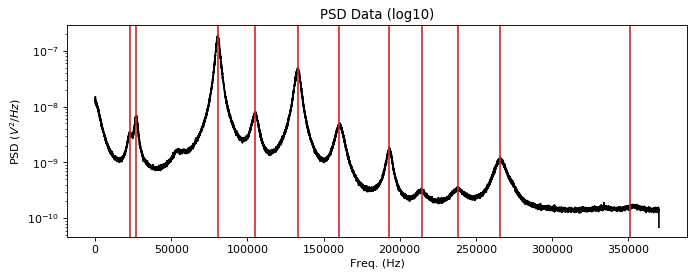

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


10823.22722929021


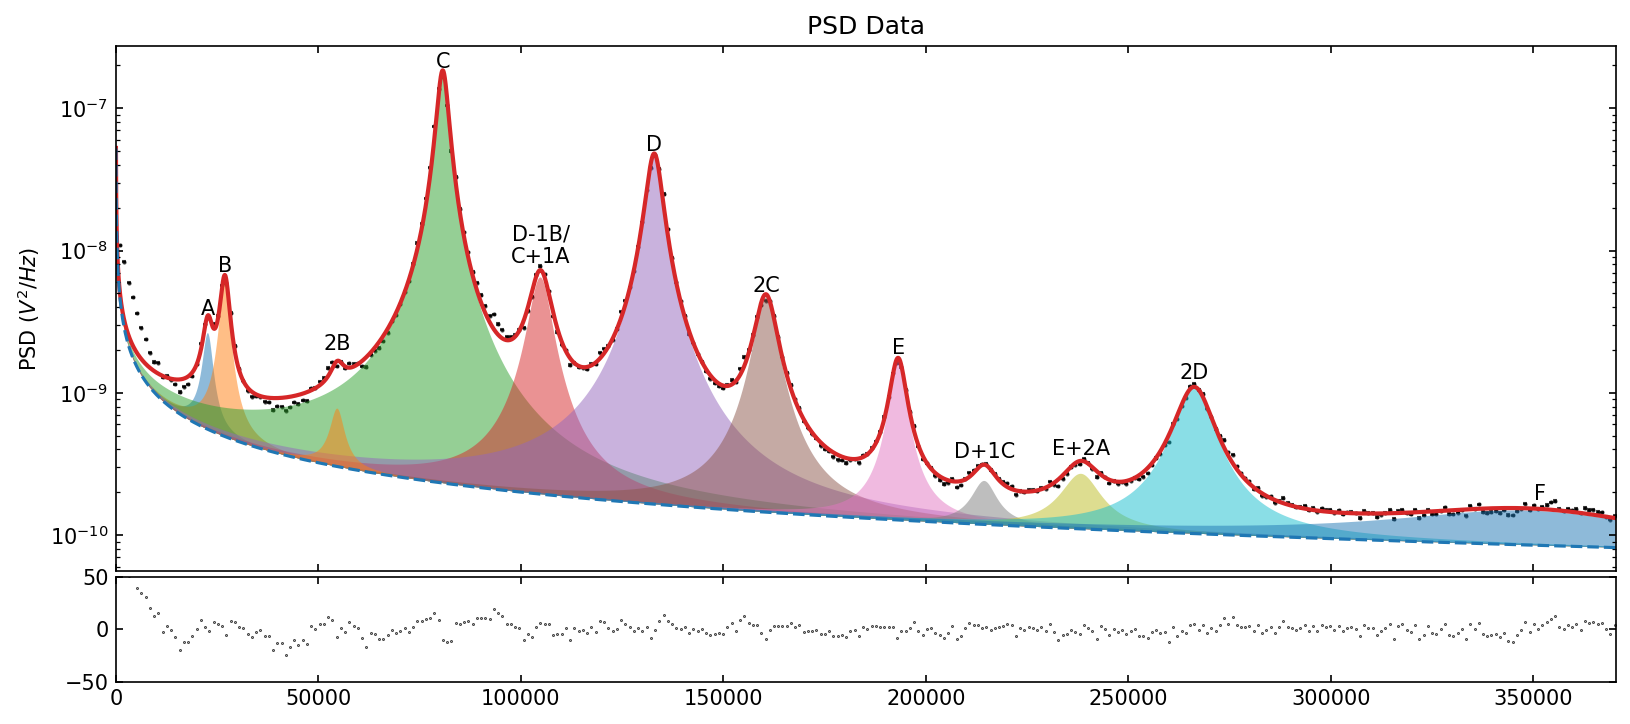

In [382]:
fit = fit_data(processed_data)
#fit.find_peaks(11)
fit.fit_n_plot(0, 2, 0, 1e0, 1e4, 1)
#fit.fit_multipeak(0, 2, 0, 1e0, 1e4, 1)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


3339135.680470918


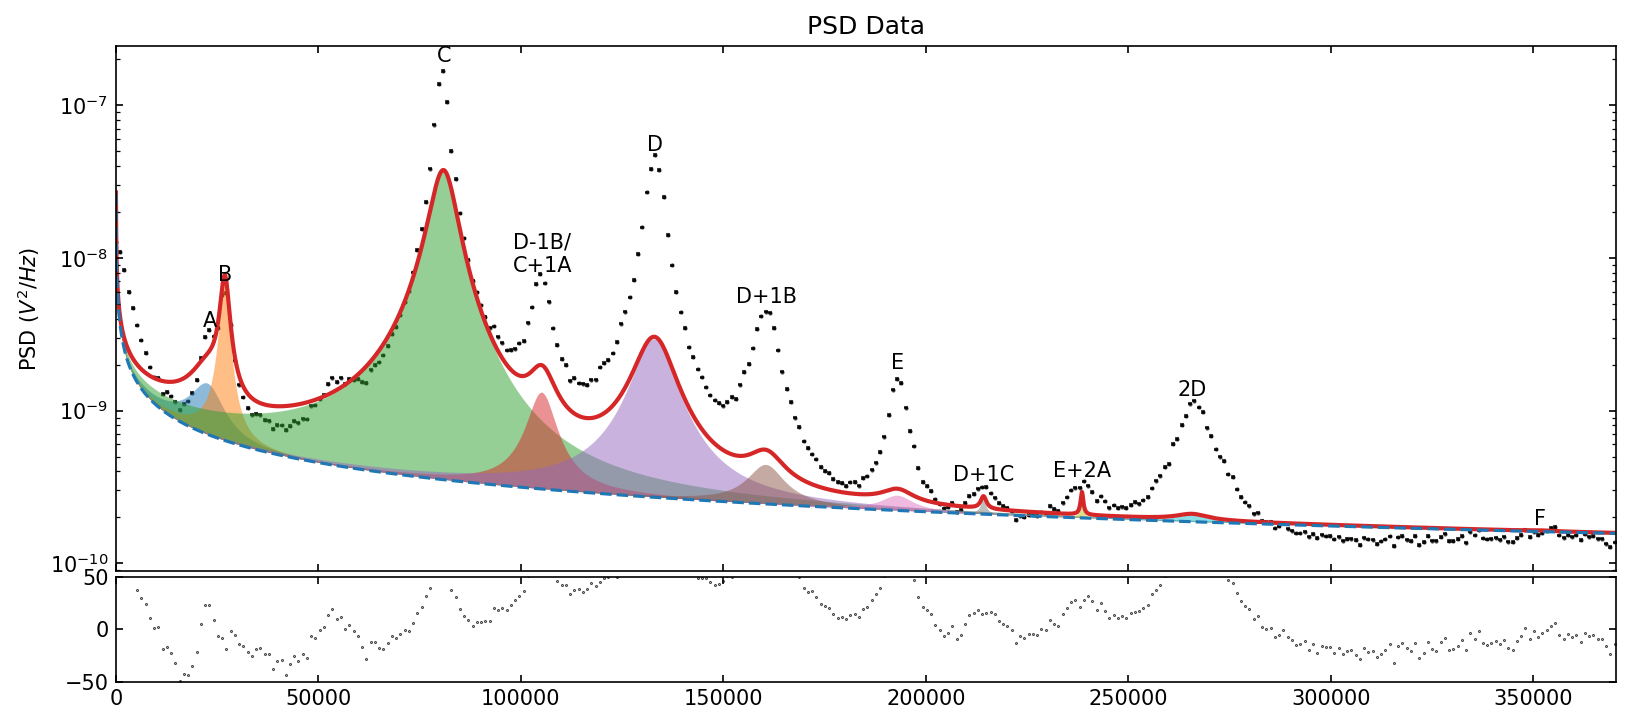

[1.55912177e-07 5.39781672e-01 3.16078296e-12 2.95644292e+00
 2.32895969e+04 8.81406001e+03 3.72363226e+03 2.69504587e+04
 2.34944074e+03 1.08106690e+04 8.10174865e+04 6.87604968e+03
 1.67332535e+06 1.05322042e+05 7.31495861e+03 8.13411305e+04
 1.33134489e+05 1.05683858e+04 4.97187875e+05 1.60689699e+05
 1.00513324e+04 5.08394101e+04 1.93127353e+05 9.08806344e+03
 1.87868825e+04 2.14243549e+05 1.61575383e+03 3.50847185e+03
 2.38551607e+05 7.66367294e+02 3.70293934e+03 2.65844454e+05
 9.52678213e+03 1.24447419e+04 3.51715251e+05 7.64573992e+03
 1.56030383e+03]
